# 라이브러리

In [1]:
# 데이터 불러오기
import psycopg2
import json

# 데이터 전처리
import pandas as pd
import numpy as np
import re
import datetime

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

# 기타
import warnings
warnings.filterwarnings("ignore")

# 데이터 불러오기

In [2]:
#Cluster된 데이터 불러오기
import pickle
clustered = pd.read_pickle("./data/clustered_apartment.pkl")
clustered.head(5)

,apartment_id,cluster
0,1,3
1,3,3
2,4,5
3,5,5
4,6,5


In [3]:
def call_df(table_name):
    with open('config.json', 'r') as f:
        config = json.load(f)
        
    conn = psycopg2.connect(user = config['USER'],
                              password = config['PASSWORD'],
                              host = config['HOST'],
                              port = config['PORT'],
                              database = config['DATABASE'])
    
    sql = f'SELECT * FROM {table_name}'
    df = pd.read_sql_query(sql, conn)
    conn.close()
    return df

In [4]:
price = call_df('crawling_db.price_table')
price['area'] = price['area'].apply(lambda x: int(re.split('\D',x)[0]))
apartment = call_df('crawling_db.apartment_table')
apartment = apartment[['apartment_id','apartment_name']]

In [5]:
df = (apartment.
      merge(clustered, how='left', on='apartment_id').
      merge(price, how='left', on='apartment_id'))

In [6]:
df['period'] = pd.to_datetime(df['period'], format='%Y.%m')

In [85]:
df = df[['period','apartment_name','area','amount','cluster']]
df.head(10)

,period,apartment_name,area,amount,cluster
0,2020-03-01,상수두산위브,104.0,1.200000e+09,3
1,2020-02-01,상수두산위브,104.0,1.200000e+09,3
2,2019-12-01,상수두산위브,104.0,1.035000e+09,3
3,2019-11-01,상수두산위브,104.0,1.025000e+09,3
4,2019-10-01,상수두산위브,104.0,9.600000e+08,3
5,2019-08-01,상수두산위브,104.0,9.200000e+08,3
6,2019-06-01,상수두산위브,104.0,8.650000e+08,3
7,2019-02-01,상수두산위브,104.0,7.900000e+08,3
8,2018-12-01,상수두산위브,104.0,9.750000e+08,3
9,2018-08-01,상수두산위브,104.0,8.050000e+08,3


# 데이터 전처리

In [62]:
#사용자 옵션
user_option = {
    'apartment_name':'우남푸르미아', # 검색하고 싶은 아파트의 이름
    'apartment_area':102, # 그 아파트의 면적
}

In [63]:
#해당 cluster 찾기
group_name = df.loc[df['apartment_name'] == user_option['apartment_name'],'cluster'].values[0]
print(f"{user_option['apartment_name']} 아파트의 그룹은 {group_name}입니다.")

우남푸르미아 아파트의 그룹은 9입니다.


In [64]:
#cluster에 해당 되는 모든 아파트를 담은 dataframe
chosen_cl = df[df['cluster']==group_name]
chosen_cl

,period,apartment_name,area,amount,cluster
2201,2015-10-01,뉴현대파크빌,79.0,380000000.0,9
2202,2006-11-01,뉴현대파크빌,79.0,283000000.0,9
2203,2015-03-01,뉴현대파크빌,80.0,358000000.0,9
2204,2006-08-01,뉴현대파크빌,80.0,294000000.0,9
2205,2019-10-01,뉴현대파크빌,80.0,607000000.0,9
...,...,...,...,...,...
460231,2019-11-01,중화동양엔파트,105.0,595000000.0,9
460232,2015-03-01,중화동양엔파트,105.0,367000000.0,9
460233,2015-01-01,중화동양엔파트,105.0,367000000.0,9
460234,2014-11-01,중화동양엔파트,105.0,367000000.0,9


In [65]:
#날짜만 있는 빈 dataframe
empty = df['period'].sort_values().reset_index()
empty = empty.dropna(axis=0).drop_duplicates(['period'])

In [66]:
#사용자 옵션에 해당 하는 아파트와 면적을 지닌 dataframe
chosen = df[(df['apartment_name'] == user_option['apartment_name']) &
            (df['area'] <= user_option['apartment_area']+3) &
            (df['area'] >= user_option['apartment_area']-3)]

In [67]:
#빈 dataframe에 해당 옵션에 해당하는 dataframe을 합치면 값이 없는 곳에 na로 채워지게 된다.
temp = empty.merge(chosen,how='left',on='period')
temp.groupby(temp['period']).mean()
temp = temp.reset_index()
temp = temp[['period','amount']]

In [68]:
#처음 거래된 날짜로 부터 시작을 해본다
starting_point = temp[temp['amount'].notnull()].index[0]
ending_point = temp[temp['amount'].notnull()].index[-1]
temp = temp[starting_point:ending_point+1].reset_index()
temp = temp[['period','amount']]
temp.tail(15)

,period,amount
167,2019-01-01,NaN
168,2019-02-01,NaN
169,2019-03-01,NaN
170,2019-04-01,473000000.0
171,2019-05-01,455000000.0
172,2019-06-01,NaN
173,2019-07-01,NaN
174,2019-08-01,495000000.0
175,2019-09-01,NaN
176,2019-10-01,NaN


In [69]:
# na 값 채워주기 
for index, row in temp.iterrows():
    if np.isnan(temp['amount'][index]):
        starts = temp['amount'][index-1]
        new_index = index
        stopping = True
        while stopping:
            if np.isnan(temp['amount'][new_index+1]):
                new_index = new_index + 1
            else:
                ends = temp['amount'][new_index+1]
                stopping = False
        
        new = chosen_cl[chosen_cl['period']==temp['period'][index]]
        
        
        if starts > ends :
            groups = new[(new['amount'] <= starts) & (new['amount'] >= ends)]
        else:
            groups = new[(new['amount'] <= ends) & (new['amount'] >= starts)]
        
        if groups.empty:
            temp['amount'][index] = (starts+ends)/2
        else:
            temp['amount'][index] = groups['amount'].quantile(0.75)
        
        

In [70]:
temp = temp.set_index('period')
temp.tail(15)

,amount
period,
2019-01-01,4.722500e+08
2019-02-01,4.726250e+08
2019-03-01,4.728125e+08
2019-04-01,4.730000e+08
2019-05-01,4.550000e+08
2019-06-01,4.872500e+08
2019-07-01,4.945000e+08
2019-08-01,4.950000e+08
2019-09-01,5.085000e+08


# 모델링

# Arima

In [71]:
## 최근 4개월을 test로 설정하고, 그 외 나머지는 train으로 설정한다 (Data Split)
temp_for_train = temp[0:len(temp)-4]
temp_for_test = temp[len(temp)-4:len(temp)]

In [72]:
from pandas.plotting import autocorrelation_plot
%matplotlib inline

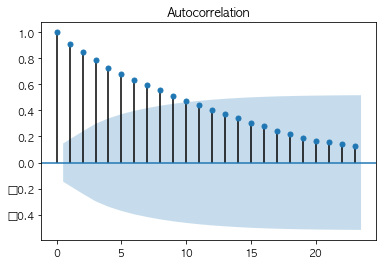

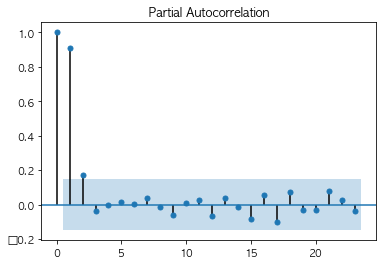

In [73]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(temp_for_train)
plot_pacf(temp_for_train)
plt.show()

AR의 경우에는 lag가 갑자기 낮아지는 경우가 없기 때문에 p=0, MA의 경우는 1 이후에 갑자기 낮아지기 때문에 q=1로 parameter를 설정

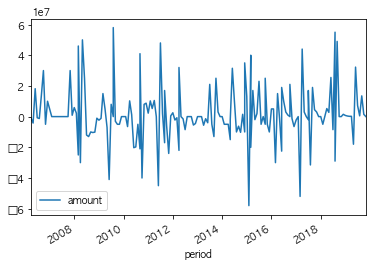

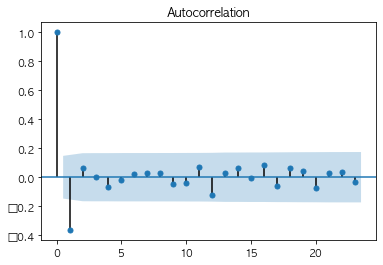

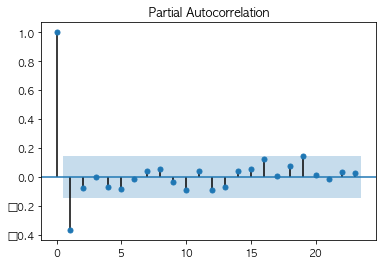

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

diff_1=temp_for_train.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

차분 역시 1번 차분한 뒤에 파란색 띄에 점들이 그려지는 것으로 보아 d=1로 설정

In [75]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(temp_for_train, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=False)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.amount   No. Observations:                  177
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3193.670
Method:                       css-mle   S.D. of innovations       16584210.366
Date:                Tue, 23 Jun 2020   AIC                           6393.339
Time:                        03:33:34   BIC                           6402.868
Sample:                             1   HQIC                          6397.204
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.61e+06    7.8e+05      2.064      0.039    8.08e+04    3.14e+06
ma.L1.D.amount    -0.3762      0.068     -5.498      0.000      -0.510      -0.242
                                    

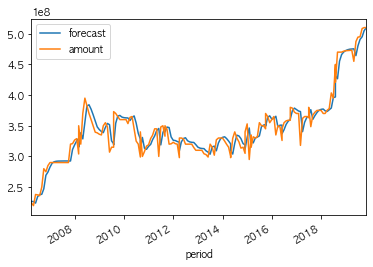

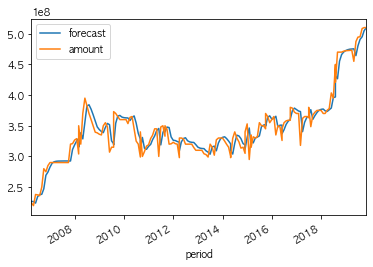

In [76]:
model_fit.plot_predict()

In [77]:
predict_month = int(input("몇 개월 앞을 예측하십니까?"))

몇 개월 앞을 예측하십니까?4


In [78]:
fore = model_fit.forecast(steps=predict_month)
arima = pd.DataFrame(fore[0])
arima.index = temp_for_test.index
result = pd.concat([temp_for_test,arima],axis=1)
result.columns = ['real','model']
result

,real,model
period,,
2019-12-01,509999999.0,5.115132e+08
2020-01-01,530000000.0,5.131234e+08
2020-02-01,540000000.0,5.147335e+08
2020-03-01,542000000.0,5.163437e+08


성능면에서 보았을 때 모델링 부분에서 개선해야할 점이 많다. 예측 월 수가 많아질수록 실제 데이터와 예측한 값의 괴리가 커지는 것을 확인할 수 있다.
우선 아파트의 경우에는 random 하게 결측치가 존재하고, 이를 다른 sample로 부터 채워넣는 방식을 채택했기 때문에, train/test 데이터를 정확하게 나누고 검증을 하는 데 있어서 모델링이 정교하지 못하였다.
또한, 각 아파트마다 변수들과 속성이 다르기 때문에 절대적인 p,q,d 값을 설정할 수 없다. 앞선 아파트의 경우에는 p=0,q=1,d=1로 설정하였지만, 다른 아파트도 이와 같은 parameter를 갖는다고 단정할 수 없다. 이와 같은 이유 때문에 auto_arima라는 모델링을 고안하였다.

# Auto_Arima

In [88]:
import pmdarima as pm

In [89]:
model = pm.auto_arima(temp_for_train,seasonal=True,m=12)

In [90]:
forecasts = model.predict(temp_for_test.shape[0])

In [91]:
arima = pd.DataFrame(forecasts)
arima.columns = ['arima']
arima.index = temp_for_test.index
result = pd.concat([temp_for_test,arima],axis=1)
result.columns = ['real','model']
result

,real,model
period,,
2019-12-01,509999999.0,5.122137e+08
2020-01-01,530000000.0,5.139872e+08
2020-02-01,540000000.0,5.158482e+08
2020-03-01,542000000.0,5.176918e+08


Auto_arima 모델링을 진행하였을 때, 따로 parameter를 설정하지 않아도 자동으로 처리가 되어 앞선 arima 모델에서 야기되었던 문제점을 어느정도 해결할 수 있었다. 실제로 성능이 조금 좋아진 것 역시 확인할 수 있다.
본래는 이와 같은 Auto_arima 모델을 사용하려고 했지만, 다음의 이유로 인해 이전 방법인 ARIMA 모델을 다시 사용하게 되었다.
몇개월 후의 아파트 가격을 예측하기로 사용자가 설정을 하고 shell을 실행하였을 때, auto arima의 경우에는 시간이 상당히 많이 소요되는 것을 확인할 수 있었다. 이와 같은 이유로 성능과 속도의 tradeoff가 발생하여, 조원끼리 상의하여 속도를 선택하는 쪽으로 진행하기로 결정하였다.

In [92]:
#최종적으로 parameter (0,1,1) 을 가지는 ARIMA 모델을 최종 결정하였고
#실제 데이터 전체를 fit 한다
model = ARIMA(temp, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=False)
fore = model_fit.forecast(steps=predict_month)
arima = pd.DataFrame(fore[0])

In [93]:
#최종 예측 모형
p = []
for i in range(1,predict_month+1):
    p.append(i)
    
arima.index = p
arima

,0
1,5.416434e+08
2,5.433948e+08
3,5.451462e+08
4,5.468976e+08
